# Introduction to Forecasting Office Occupancy with Prophet

In this Jupyter notebook, we utilize Facebook's Prophet, a powerful and flexible forecasting tool, to predict office occupancy based on our cleaned and processed dataset. Prophet is designed to handle the intricacies of time series data with daily and seasonal trends, making it an ideal choice for predicting complex patterns such as those found in office attendance and room bookings.

The process begins with loading the preprocessed dataset, ensuring datetime formats are correct, and then splitting the data into training and testing sets. We configure the Prophet model with appropriate seasonality and additional regressors to capture the nuances of our occupancy data. Once the model is trained, we make predictions on the test set and visualize the results, comparing the forecasted occupancy against the actual data.

To provide a comprehensive evaluation of the model's performance, we compute several accuracy metrics, including MAE (Mean Absolute Error), RMSE (Root Mean Square Error), MAPE (Mean Absolute Percentage Error), and the R-squared statistic. These metrics will help us understand the model's precision and predictive power.

Finally, we save the trained model for future forecasting, enabling us to make occupancy predictions with the click of a button. This notebook encapsulates the end-to-end process of building a time series forecasting model, from data preparation to model evaluation and deployment.

### Initializing the Forecasting Process

As we set out to predict office occupancy, our first step is to gather the tools that will power our analysis. We import a suite of Python libraries and modules, each playing a pivotal role in the forecasting workflow:

- **Prophet**: Developed by Facebook, this library is tailored for forecasting time series data with its robust handling of seasonality, trends, and holidays.
- **Pandas**: Our data manipulation workhorse, it allows us to structure, explore, and manipulate the data easily.
- **Matplotlib**: This plotting library will enable us to visualize the data and the forecasting results, providing clear insights into the performance of our model.
- **NumPy**: Essential for numerical operations, especially when transforming or reverting transformations on our data.
- **Scikit-learn Metrics**: These functions allow us to quantitatively assess the performance of our model through various error metrics.
- **Pickle**: A module for saving our model, which ensures that we can quickly load the trained model for future predictions without retraining.

Equipped with these tools, we're ready to begin transforming our preprocessed data into forecasts that can inform decision-making and strategy for office management.


In [99]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle


### Loading the Preprocessed Dataset for Forecasting

With our environment prepared, we now load the preprocessed dataset that will be used for forecasting office occupancy. This dataset, saved from the previous stages of cleaning and preparation, contains the time series data that Prophet will use to fit its model.

By inspecting the first few rows with `df_prophet.head()`, we ensure that the data is loaded correctly and get a quick glimpse of its structure. This verification step is critical to confirm that the data aligns with our expectations and is ready for the modeling phase.


In [100]:


# Load the dataset
df_prophet = pd.read_csv('./data/df_prophet.csv')
df_prophet.head()


,Unnamed: 0,ds,y,y_original,expected_occupancy,month,day_of_week,is_workday
0,0,2023-01-02 08:00:00,3.688879,39,0.0,1,0,1
1,1,2023-01-02 09:00:00,3.465736,31,0.0,1,0,1
2,2,2023-01-02 10:00:00,3.555348,34,0.0,1,0,1
3,3,2023-01-02 11:00:00,3.401197,29,0.0,1,0,1
4,4,2023-01-02 12:00:00,3.044522,20,0.0,1,0,1


### Preparing the Time Series Data for Prophet

To ensure compatibility with the Prophet forecasting model, we must confirm that the datetime column, `ds`, is in the correct format. Prophet requires this column to be a datetime type without any timezone information—referred to as "timezone-naive."

This step involves converting the `ds` column to datetime format and removing any timezone information that may be attached, thereby meeting Prophet's data specifications. This process is vital for the model to correctly interpret the timestamps and for the successful fitting and forecasting of time series data.


In [101]:

# Ensure 'ds' is datetime and timezone-naive
df_prophet['ds'] = pd.to_datetime(df_prophet['ds']).dt.tz_localize(None)


### Splitting the Data for Training and Testing

Before we can train our forecasting model, we need to divide our dataset into two subsets: one for training the model and another for evaluating its performance. This split allows us to understand how well the model can predict new, unseen data.

We allocate 80% of the data for training, which provides the model with a substantial historical context to learn the occupancy patterns. The remaining 20% is reserved for testing, giving us a clear measure of the model's forecasting accuracy.

By carefully splitting the data, we ensure that our model's performance evaluation is both rigorous and fair, providing a trustworthy assessment of its predictive capabilities.


In [102]:

# Split the data into training and testing sets
train_ratio = 0.8
split_index = int(len(df_prophet) * train_ratio)
train = df_prophet.iloc[:split_index]
test = df_prophet.iloc[split_index:]


### Configuring the Prophet Model

We start by setting up the Prophet model with the following configurations to ensure it can effectively model the daily and hourly seasonality observed in office occupancy data:

- **Daily Seasonality Enabled**: This setting allows the model to account for variations in occupancy that occur on a day-to-day basis, which is crucial for capturing the regular fluctuations associated with standard working hours and off-hours.

- **Changepoint Prior Scale**: We set this parameter to `0.01` to control the model's flexibility in detecting changes in the trend. A smaller value makes the model less sensitive to changes, helping to prevent overfitting to minor fluctuations and focusing on more significant shifts in occupancy trends.

- **Custom Hourly Seasonality**: To further refine the model's accuracy, we add a custom hourly seasonality component. This is particularly important for office occupancy forecasting, where there can be distinct patterns within the working day, such as peak occupancy times. We set the period to `1/24` to represent the hourly cycle within a day and choose a Fourier order of `8`. This Fourier order allows the model to capture the primary occupancy patterns without becoming overly complex.

These settings are designed to optimize the Prophet model for the specific characteristics of office occupancy data, ensuring that both broad trends and finer-grained daily and hourly patterns are accurately captured.



In [103]:

# Initialize the Prophet model with all settings
model = Prophet(daily_seasonality=True, changepoint_prior_scale=0.02)
model.add_seasonality(name='hourly', period=2, fourier_order=50)


### Enhancing the Prophet Model with Additional Regressors

To further refine our office occupancy forecasts, we incorporate additional regressors into the Prophet model. These regressors provide the model with more context, allowing it to account for factors that significantly influence occupancy beyond the basic time series trends and seasonality.




- **Adding Additional Regressors**: We enhance the model by introducing several additional regressors: `is_workday`, `expected_occupancy`, `day_of_week`, and `month`. Each of these factors is expected to have a distinct impact on office occupancy, from daily and monthly patterns to variations based on whether a day is a workday.


In [104]:

# Add additional regressors
additional_regressors = [ 'is_workday', 'expected_occupancy', 'day_of_week', 'month'] 
for regressor in additional_regressors:
    model.add_regressor(regressor)



- **Training the Model**: With the additional regressors configured, we proceed to fit the model to our training dataset. This step allows the model to learn the underlying patterns in the data, including how the additional regressors influence occupancy.



In [105]:

# Fit the model to the training data
model.fit(train)


15:59:27 - cmdstanpy - INFO - Chain [1] start processing
15:59:27 - cmdstanpy - INFO - Chain [1] done processing



- **Forecasting Future Occupancy**: After training, we prepare the testing dataset by excluding the target variable (`y`) to simulate a real forecasting scenario. We then use the trained model to predict future occupancy for the dates within our testing set.




In [106]:

# Make predictions on the testing set
future = test.drop(columns=['y'])  
forecast = model.predict(future)





## Insights:

- By integrating additional regressors, we provide the model with a richer set of data points to consider, enabling more accurate and nuanced forecasts.
- The process of fitting the model and making predictions mirrors real-world forecasting tasks, where models are trained on historical data and used to predict future outcomes based on similar conditions.
- The inclusion of `is_workday` as a regressor is particularly noteworthy, as it allows the model to differentiate between workdays and weekends or holidays, which is crucial for accurate occupancy forecasting in an office context.
```

This approach exemplifies how to leverage the Prophet model's flexibility to incorporate external factors into time series forecasting, aiming for enhanced prediction accuracy and relevance to specific use cases like office occupancy.

### Visual Comparison of Actual vs. Forecasted Occupancy

The visualization of actual versus forecasted office occupancy provides a clear picture of the model's performance. By plotting both the actual values and the forecasted values on a logarithmic scale, we gain insights into the accuracy of our predictions.

#### Code Explanation:


- **Visualization of Forecasting Results**: The graph illustrates the comparison between the actual occupancy data and the values predicted by the model. The use of a logarithmic scale helps in comparing growth rates and percentage changes more effectively.

- **Confidence Intervals**: The shaded area represents the confidence intervals (`yhat_lower` and `yhat_upper`) of the forecasts, providing a visual sense of the model's certainty in its predictions.

- **Chart Details**: The plot includes labels for the axes (`Date` and `Values`), a title ('Actual vs Forecast (Logarithmic scale)'), and a legend to distinguish between the actual and forecasted data.



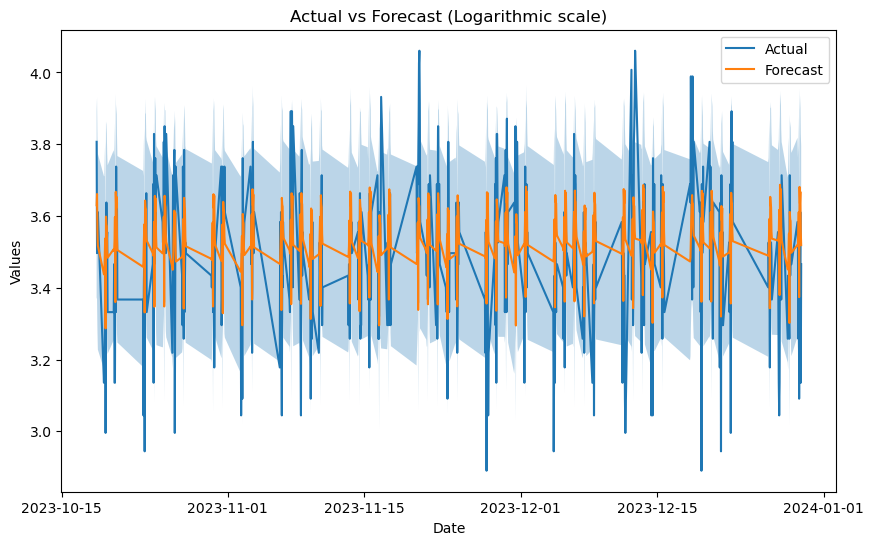

In [107]:
# Compare forecast to actual values
plt.figure(figsize=(10, 6))
plt.plot(test['ds'], test['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Actual vs Forecast (Logarithmic scale)')
plt.legend()
plt.show()

#### Insights:

- **Model Evaluation**: This visual comparison is an integral part of model evaluation, as it allows us to quickly assess how well the forecasted trends and patterns align with the actual occupancy data.

- **Forecasting Accuracy**: Areas where the forecast diverges significantly from the actual data can identify periods where the model may need refinement or where external factors may have influenced occupancy levels.

- **Decision Making**: For office management, such visualizations can be instrumental in making informed decisions based on the forecasted occupancy, helping to plan for future space utilization and resource allocation.





## Visualizing Forecast Accuracy on the Original Scale
After training our forecasting model and making predictions, it's essential to assess the model's performance by comparing the forecasted values with the actual data. 

### Reverting Log Transformations for Comparison
We initially applied a logarithmic transformation to stabilize the variance in our occupancy data. For a meaningful comparison between the predicted and actual values, we need to revert this transformation to the original scale:

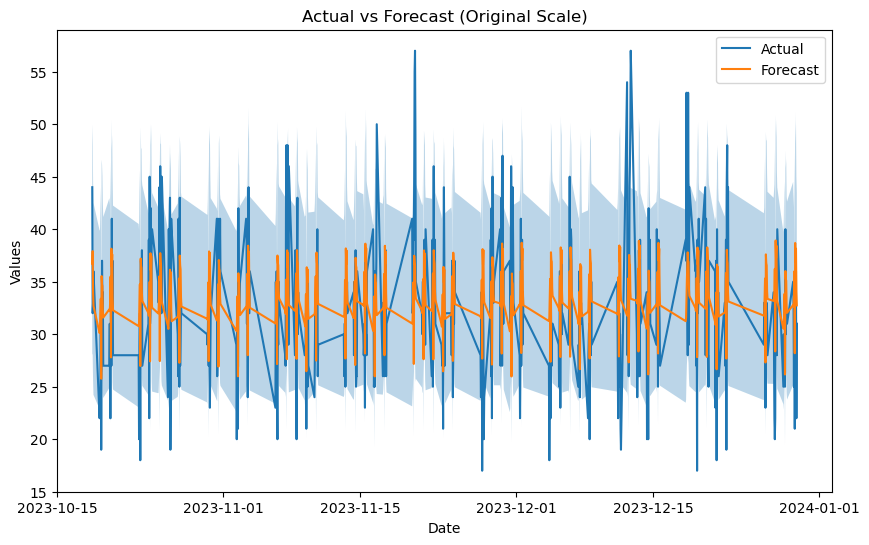

In [108]:
# Revert the log transformation on the forecasted values
forecast['yhat_original'] = np.expm1(forecast['yhat'])
forecast['yhat_lower_original'] = np.expm1(forecast['yhat_lower'])
forecast['yhat_upper_original'] = np.expm1(forecast['yhat_upper'])

# Plot the actual vs forecasted values
plt.figure(figsize=(10, 6))
plt.plot(test['ds'], np.expm1(test['y']), label='Actual')  # Ensure to revert the test['y'] as well since it's on log scale
plt.plot(forecast['ds'], forecast['yhat_original'], label='Forecast')
plt.fill_between(forecast['ds'], forecast['yhat_lower_original'], forecast['yhat_upper_original'], alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Actual vs Forecast (Original Scale)')
plt.legend()
plt.show()


### Evaluating Model Performance with Error Metrics

After transforming our predicted and actual occupancy values back to their original scale, we proceed to quantitatively assess the forecasting model's accuracy. This is done using two common statistical error metrics: Mean Absolute Error (MAE) and Root Mean Square Error (RMSE).

#### Calculating Error Metrics


To quantify the forecast accuracy, we calculate:
- **Mean Absolute Error (MAE)**: This metric provides the average magnitude of errors in a set of forecasts, without considering their direction (positive or negative). It is a measure of accuracy for continuous variables and is particularly useful when we want to understand the error size in the same units as the data itself.
- **Root Mean Square Error (RMSE)**: This metric provides a measure of the average magnitude of the error, giving a relatively high weight to large errors. This means the RMSE should be more useful when large errors are particularly undesirable.

By reporting both MAE and RMSE, we gain a more comprehensive understanding of the model's performance, capturing both the average error and the variability of the errors.

In [83]:

#  y_true are the actual values and y_pred are the predicted values

y_true = np.expm1(test['y']).values
y_pred = np.expm1(forecast['yhat']).values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))


print(f"MAE: {mae}")
print(f"RMSE: {rmse}")



MAE: 3.814677783318604
RMSE: 4.948092363386668


#### Interpreting the Output

The given output indicates the average error (MAE) and the standard deviation of the errors (RMSE) between the forecasted and actual occupancy numbers:

The output of the error metrics is as follows:
- **MAE**: A value of `3.814677783318604` suggests that, on average, the model's predictions are approximately 3.81 occupancy counts off from the actual counts.
- **RMSE**: A value of `4.948092363386668` indicates the typical deviation of the forecast errors. The higher value compared to MAE suggests there are some larger errors in the dataset.

These metrics serve as benchmarks for the model's current predictive performance. Depending on the context and the acceptable error thresholds for occupancy predictions, these values can inform whether the model's accuracy is sufficient or if further improvements are necessary.


Understanding the magnitude of these errors in the context of your specific application is essential. If the errors are within an acceptable range, the model can be considered reliable for practical use. If not, these metrics can guide further model refinement or prompt a review of the underlying data and model assumptions.

### Saving the Trained Prophet Model

After training and validating our Prophet model, we want to save it for future use. This way, we don't need to retrain the model every time we wish to make predictions, which saves time and computational resources.

In [92]:
with open('./model/prophet_model.pkl', 'wb') as file:
    pickle.dump(model, file)

The result is a saved model file, `prophet_model.pkl`, which contains all the information needed to load the trained model at a later date and make predictions without having to retrain from scratch.

### Conclusion: Ready for Future Predictions


With our Prophet model trained, evaluated, and saved, we conclude this phase of our forecasting project. We have successfully navigated through data preprocessing, model tuning, prediction, and evaluation, culminating in the serialization of our model for future use.

This serialized model stands as a milestone, encapsulating our analytical efforts and serving as a ready-to-use tool for predicting office occupancy. It can be quickly loaded to provide insights, support decision-making, or integrate with operational systems to manage office space efficiently.

As we wrap up this notebook, we look forward to leveraging the model to its full potential, confident in the robust foundation we have built through careful data science practices.

